In [1]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../../"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils
from explainer.itemsets_miner import transform_intgrad_to_itemsets,gen_freq_feature_set
import explainer.integrad as integrad

from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve
from itertools import permutations

In [5]:
# Define a simple CNN model
class Net(nn.Module):
    def __init__(self,image_w=28,image_h=28,num_class=10,input_channel=1,output_channel=4,kernel=4,hidden_state=128):
        super(Net, self).__init__()
        self.output_channel = output_channel
        self.w = int((image_w - kernel + 1)/2)
        self.h = int((image_h - kernel + 1)/2)
        
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel)  # 1 input channel, 32 output channels, 5x5 kernel
       
        self.fc1 = nn.Linear(output_channel * self.w * self.h, hidden_state)  # Fully connected layer with 10 output classes
        self.fc2 = nn.Linear(hidden_state, num_class)
        
    def latent1(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, self.output_channel * self.w * self.h)
        return x
    
    def latent2(self,x):   
        x = self.latent1(x)
        x = F.relu(self.fc1(x))
        return x
        
    def forward(self, x):
#         x = self.latent1(x)
        x = self.latent2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def latent_representation(self,x):
        #x = self.latent2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [6]:
## Control randomness for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Load and preprocess data

In [7]:

# Specify where to download or read the data
dpath = "./data/" 

# Define data transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root=dpath, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

# Define data transformations and load the MNIST test dataset
testset = torchvision.datasets.MNIST(root=dpath, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)


## Train CNN classifier

In [8]:
model_path = "./model/cnn"

if os.path.exists(model_path):
    ### load the trained model
    model = torch.load(model_path)

else:
    # Initialize the model and optimizer
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training loop
    for epoch in range(50):  # Change the number of epochs as needed
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 400 == 399:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 400:.3f}')
                running_loss = 0.0
    torch.save(model, model_path)
    print('Finished Training')

In [9]:
## Evaluate on test set

correct = 0
total = 0
y_test, pred_y_test,pred_prob_test = [],[],[]
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        y_test.append(labels) 
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        pred_y_test.append(predicted) 
        pred_prob_test.append(torch.softmax(outputs,dim=1))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
y_test = torch.concat(y_test).numpy()
pred_y_test = torch.concat(pred_y_test).numpy()
pred_prob_test = torch.vstack(pred_prob_test).numpy()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 98.55%


In [10]:
## Evaluate on training set

correct = 0
total = 0
X_train, X_train_raw = [],[]
y_train, pred_y_train = [],[]
train_reps = []
pred_prob_train = []
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        
        X_train_raw.append(inputs)
        X_train.append(model.latent2(inputs).detach())
        y_train.append(labels)        
        
        outputs = model(inputs).detach()
        train_reps.append(outputs) 
        predicted = torch.argmax(outputs,dim=1)
        pred_y_train.append(predicted) 
        pred_prob_train.append(torch.softmax(outputs,dim=1))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
X_train = torch.vstack(X_train)
X_train_raw = torch.vstack(X_train_raw)
train_reps = torch.vstack(train_reps)

y_train = torch.concat(y_train).numpy()
pred_y_train = torch.concat(pred_y_train).numpy()
pred_prob_train = torch.vstack(pred_prob_train).numpy()

print(f'Accuracy on the training set: {100 * correct / total:.2f}%')

Accuracy on the training set: 99.72%


y threshold 0.28734288


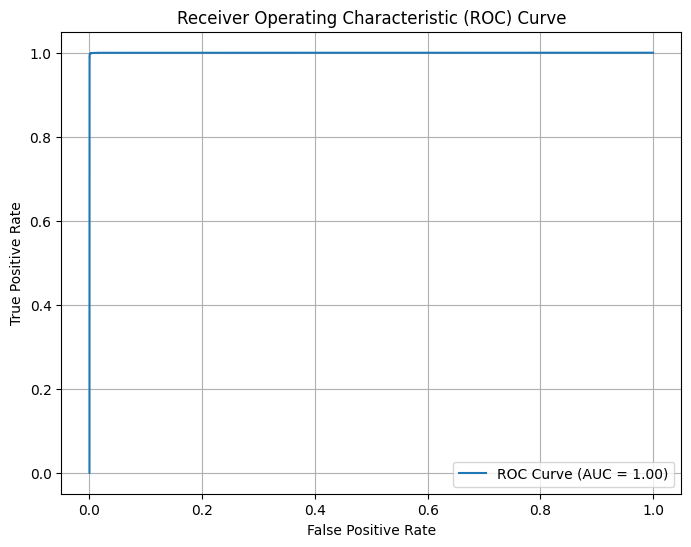

In [11]:
## AUC on training set

auc = roc_auc_score(y_train==7, pred_prob_train[:,7])
fpr, tpr, thresholds = roc_curve(y_train==7, pred_prob_train[:,7])
y_thd = thresholds[np.argmax(tpr - fpr)]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

In [12]:
## AUC on test set
roc_auc_score(y_test==7, pred_prob_test[:,7])

0.9998939632336487

## Feature selection for AMORE

In [13]:
## get baseline samples and test samples for computing impact scores of features

baselines = eutils.gen_intgrad_baselines(X_train,y_train,train_reps)
subset = eutils.gen_balanced_subset(X_train,y_train,size_per_class=1000)

In [14]:
# # If test the rule extraction methods for multiple random seeds, change the random seed here.
# # If change random seed in the begining, the model, the training, and test set will change too, the randomness will have several sources.

# seed = 0
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

In [15]:
## compute impact score matrix

### specify target class
c = 7 

### calc int grads for target class
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,C=10,target_dim=c)
y_int_g = torch.abs(int_g/z_shift[:,c].reshape(-1,1))

In [16]:
### find threshold for int grads
thds = np.linspace(0.0001,0.1,1000)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*.99).sum()))
    print(f_n[-1])
    if f_n[-1][1]<=1:
        break
thd = f_n[-1][0] 
thd

(0.0001, tensor(10))
(0.0002, tensor(3))
(0.00030000000000000003, tensor(2))
(0.0004, tensor(1))


0.0004

In [17]:
### find frequent feature set
itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd)
fids = gen_freq_feature_set(itemsets_y[0],min_support=1000,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

feature set [ 44  20 105  66   5  15  88 114  68  28  60  17  33  19  77 121   6 110
  14  38  76  58  12  36 111  80  99] 27


## Extract rules by AMORE

In [30]:
## set "grid_search = True" to do a grid search for hyperprameters
feature_names = ["z"+str(i) for i in range(X_train.shape[1])]
grid_search = True

if grid_search:
    ng_range = np.arange(2,11,1)
    bin_strategies = ["uniform","kmeans"]
    support_range = np.arange(1000,10000,1000)
    confidence_lower_bound = 0.8
    max_depth=2
    top_K=3
  

    best_rule_set,best_configs,config_metric_records = rlm.param_grid_search_for_amore(bin_strategies,ng_range,support_range,X=X_train.numpy(),
                                                                                       fids=fids,target_indices=(pred_y_train==c),y=y_train,c=c,
                                                                                       confidence_lower_bound=confidence_lower_bound,
                                                                                    max_depth=max_depth,top_K=top_K,sort_by="fitness")
    print(best_rule_set,best_configs)

grid search hyperparameters
{'rules': [(44, '>=', 6.2233706), (114, '>=', 0.0), (114, '<=', 3.1046019)], 'confidence': 0.900374531835206, 'support': 5340, 'fitness': 0.6815428753586229, 'cond_prob_y': 0.898876404494382, 'ratio_y': 0.7661612130885874} {'bin_strategy': 'kmeans', 'num_grids': 6, 'min_support': 4000}


In [61]:
### search rules for target pattern: pred_y_c == c  ###
### we set the hyperparameters obtaind by above grid search step ###

min_support = 4000 
bin_strategy="kmeans"
num_grids = 6
max_depth = 2


rule_list = rlm.gen_rule_list_for_one_target(X_train.numpy(),fids,pred_y_train==c,y=y_train,c=c,sort_by="fitness",
                                            min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=3,
                                            local_x=None,feature_types=None,search="greedy",bin_strategy=bin_strategy,
                                            verbose=False,remove_duplicate=True)

delete duplicate (5, 3.2346735, 12.658002, 44, 6.2233706, 13.227051) (44, 6.2233706, 13.227051, 5, 3.2346735, 12.658002)


In [62]:
## The rule list is sorted by fitness
rule_list[0]

{'rules': [(44, '>=', 6.2233706), (114, '>=', 0.0), (114, '<=', 3.1046019)],
 'confidence': 0.900374531835206,
 'support': 5340,
 'fitness': 0.6815428753586229,
 'cond_prob_y': 0.898876404494382,
 'ratio_y': 0.7661612130885874}

### Visualize top rules from AMORE

/var/folders/1w/jwcgd35x0rg1yln4sl7szvf80000gn/T/ipykernel_1274/1451645048.py:24: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  imgs = X_train_raw[ids]


[(44, '>=', 6.2233706)] support tensor(10585)


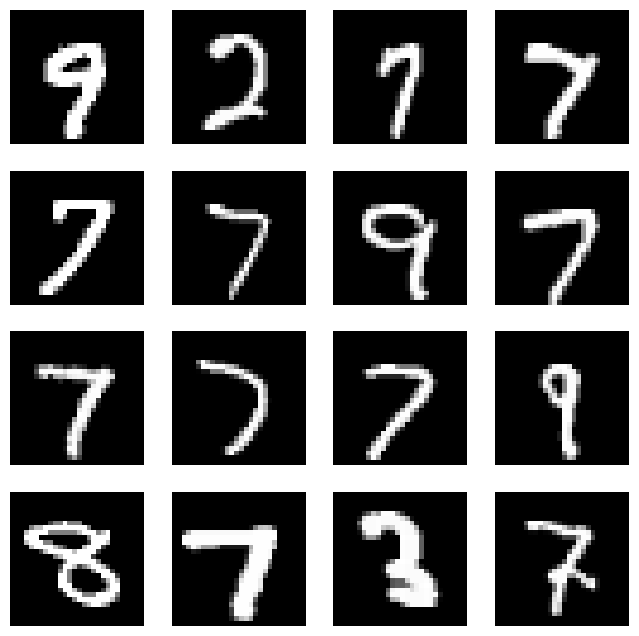

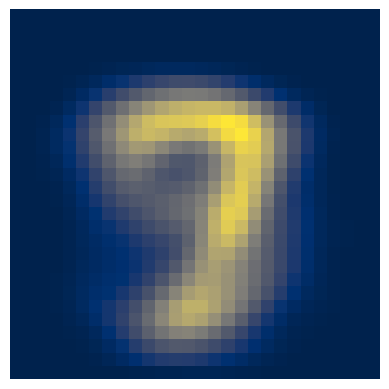

[(114, '>=', 0.0), (114, '<=', 3.1047292)] support tensor(23668)


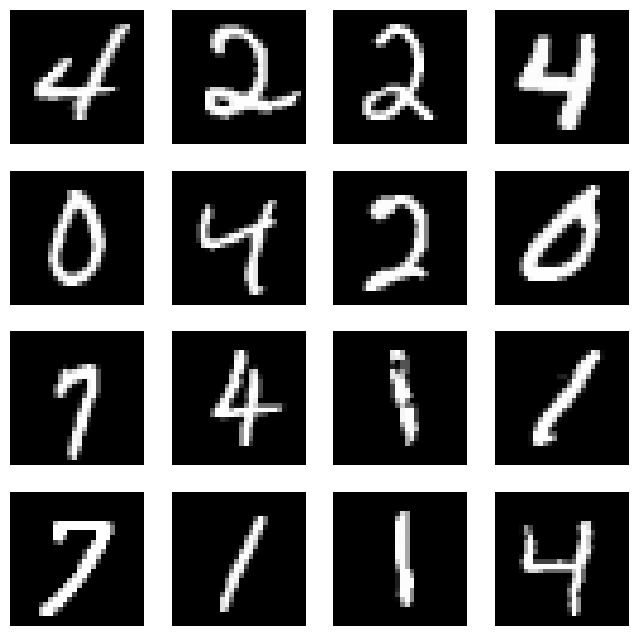

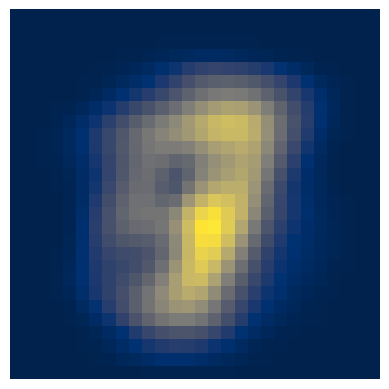

In [21]:
### visualize rules in the top rule set

tot_img = []
file_type = ".svg"
    
    
r1 = rule_list[0]["rules"]
seen = set()
keys = [r[0] for r in r1 if not (r[0] in seen or seen.add(r[0]))] ##keep the order of rules

### merge rules of the same feature 
rdict = {}
for key in keys:
    for r in r1:
        if r[0] == key:
            rdict[key] = rdict.get(key,[])
            rdict[key].append(r)

for kk,fid in enumerate(keys):
    rs = rdict[fid]
    ids = np.ones(len(X_train)).astype(bool)
    for r in rs:
        ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
    imgs = X_train_raw[ids]
    
    print(rs,"support",ids.sum())
    
    # Create a figure with 16 subplots
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    # Display 16 MNIST images
    for i in range(4):
        for j in range(4):
            index = i * 4 + j
            image = imgs[index]
            axes[i, j].imshow(image.squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.savefig("./rule_samples_c"+str(c)+"r"+str(kk)+file_type,bbox_inches="tight")
    plt.show()
    
    plt.close()
    
    avg_img = imgs.mean(axis=0).squeeze().numpy() 
    
    ### min-max normalization to highlight the higher value pixels 
    avg_img = (avg_img-avg_img.min())/(avg_img.max()-avg_img.min()) 
    
    tot_img.append(avg_img.reshape(1,28,28))
    plt.imshow(avg_img,vmin=0., vmax=1.,cmap="cividis")
    plt.axis("off")
    
    plt.savefig("./rule_average_c"+str(c)+"r"+str(kk)+file_type,bbox_inches="tight")
    plt.show()
    plt.close

    

/var/folders/1w/jwcgd35x0rg1yln4sl7szvf80000gn/T/ipykernel_1274/1894471529.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  imgs = X_train_raw[ids]


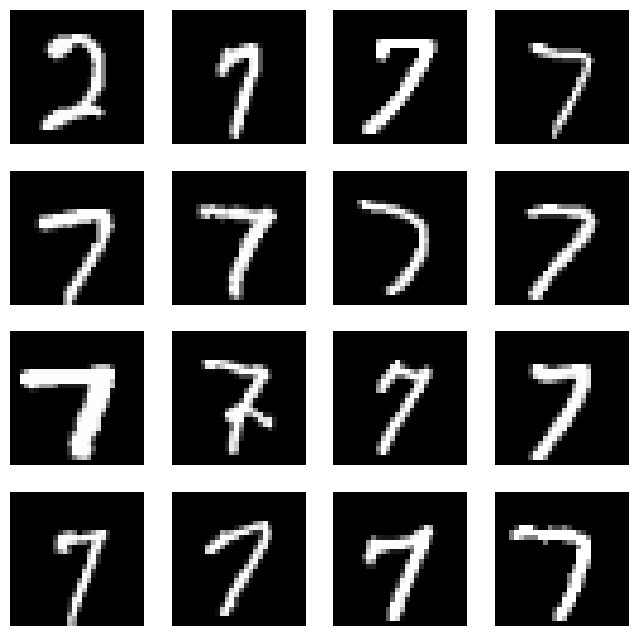

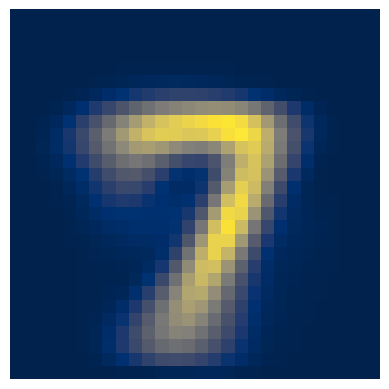

In [22]:
### visualize intersection of rules in the top rule set

ids = np.ones(len(X_train)).astype(bool)
for rv in rdict.values():    
    for r in rv:
        ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
imgs = X_train_raw[ids] 

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):
    for j in range(4):
        index = i * 4 + j
        image = imgs[index]
        axes[i, j].imshow(image.squeeze(), cmap='gray')
        axes[i, j].axis('off')
plt.savefig("./tot_rule_samples_c"+str(c)+file_type,bbox_inches="tight")
plt.show()
plt.close()

avg_img = imgs.mean(axis=0).squeeze().numpy() 
    
### min-max normalization to highlight the higher value pixels 
avg_img = (avg_img-avg_img.min())/(avg_img.max()-avg_img.min()) 


plt.imshow(avg_img,vmin=0., vmax=1.,cmap="cividis")
plt.axis("off")
plt.savefig("./tot_rule_avergae_c"+str(c)+file_type,bbox_inches="tight")
plt.show()
plt.close()

## Extract rules from Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [33]:
## set "grid_search = True" to do a grid search for hyperprameters

if grid_search:
    criteria = ["gini", "entropy", "log_loss"]
    support_range = np.arange(1000,10000,1000)
    w = (y_train==c).sum()/y_train.shape[0]
    class_weight_options = [{0:0.5,1:0.5},"balanced"]
    confidence_lower_bound = 0.8
    max_depth=2
    DT_best_rule_set, DT_best_configs, DT_config_metric_records = dtr.param_grid_search_for_DT(criteria,support_range,class_weight_options,X=X_train.numpy(),y=y_train,target_indices=pred_y_train==c,c=c,max_depth=max_depth,feature_names=feature_names,confidence_lower_bound=confidence_lower_bound,seed=seed)
    print(DT_best_rule_set, DT_best_configs)

{'rules': [(44, '>', 6.429), (114, '<=', 3.463)], 'support': 5518, 'fitness': 0.6869620656678355, 'confidence': 0.8905400507430228} {'criterion': 'entropy', 'min_support': 1000, 'class_weight': {0: 0.5, 1: 0.5}}


In [26]:
print(export_text(treemodel))

|--- feature_44 <= 6.43
|   |--- feature_44 <= 4.93
|   |   |--- class: False
|   |--- feature_44 >  4.93
|   |   |--- class: False
|--- feature_44 >  6.43
|   |--- feature_114 <= 3.46
|   |   |--- class: True
|   |--- feature_114 >  3.46
|   |   |--- class: False



In [27]:
dtr.display_rules_from_DT(rule_list,rule_metric_list,feature_names)

#################
[(44, '<=', 4.928)]
confidence 0.004 cond_prob_y 0.004 support 40518 fitness -6.411
z44 <= 4.928
#################
[(44, '<=', 6.429), (44, '>', 4.928)]
confidence 0.076 cond_prob_y 0.076 support 9899 fitness -1.336
z44 <= 6.429
z44 > 4.928
#################
[(44, '>', 6.429), (114, '<=', 3.463)]
confidence 0.891 cond_prob_y 0.889 support 5518 fitness 0.687
z44 > 6.429
z114 <= 3.463
#################
[(44, '>', 6.429), (114, '>', 3.463)]
confidence 0.112 cond_prob_y 0.111 support 4065 fitness -0.503
z44 > 6.429
z114 > 3.463


### Below code is for plotting confidence and fitness while varying minimum support¶

11 0.9732835392128699
DT 2 0.8905400507430228
2 0.9075421133231241
DT 2 0.8905400507430228
2 0.9075421133231241
DT 2 0.8905400507430228
13 0.900374531835206
DT 2 0.8905400507430228
13 0.900374531835206
DT 0 0.6886889839256747
15 0.8349808673469388
DT 1 0.8364679630219956
0 0.6660670692535012
DT 0 0.676936243046641
0 0.6125945179584121
DT 0 0.6277153558052434
0 0.1673263090335348
DT 0 0.5827593868029327


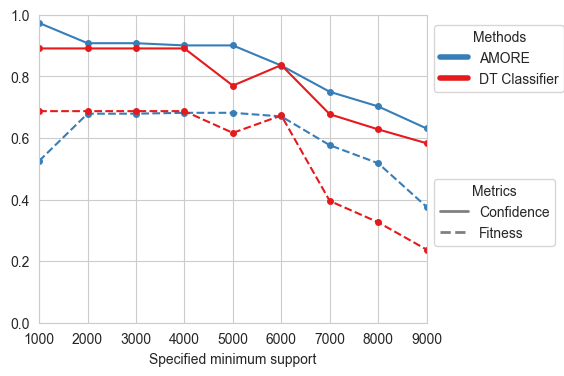

In [32]:
## Need grid search first to get the results with different minimum supports

if grid_search:
    
    cf_mtx = np.vstack([config_metric_records[key]["top_confidence_records"] for key in config_metric_records.keys()])
    ft_mtx = np.vstack([config_metric_records[key]["top_fitness_records"] for key in config_metric_records.keys()])
    
    DT_cf_mtx = np.vstack([DT_config_metric_records[key]["top_confidence_records"] for key in DT_config_metric_records.keys()])
    DT_ft_mtx = np.vstack([DT_config_metric_records[key]["top_fitness_records"] for key in DT_config_metric_records.keys()])
    
    eutils.plot_confidence_fitness_curve(cf_mtx,ft_mtx,DT_cf_mtx,DT_ft_mtx,support_range)